# Проект. Отток клиентов из банка

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. В ходе проекта необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для исследования предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Цели проекта

* Построить модель с предельно большим значением F1-меры (довести метрику до 0.59)
* Проверить F1-меру на тестовой выборке

------

## 1. Подготовка данных

Импортируем необходимые модули и библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [51]:
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл `Churn.csv` и сохраним его в переменной `data`.

In [52]:
data = pd.read_csv('/datasets/Churn.csv')

Изучим информацию о даннных.

In [53]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [55]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Имеется таблица с данными, у которой 14 столбцов и 10000 строк. Признаки, которые будут использоваться для обучения модели: *'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'*. Целевой категориальный признак - *'Exited'*. В ходе проекта будет решаться задача бинарной классификации.

В столбце *'Tenure'* имеется 909 пропусков, также у значений данного столбца нужно заменить тип данных на целочисленный.
Заменим пропуски в столбце *'Tenure'* на значение медианы.

In [59]:
data['Tenure'] = data['Tenure'].fillna(5)

In [60]:
data['Tenure'] = data['Tenure'].astype('int')

Посмотрим, что получилось.

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [62]:
data.nunique() 

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [63]:
data.describe(include=object)

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Проверим уникальность клиентов.

In [64]:
data['CustomerId'].nunique()

10000

Дубликатов в данных нет.

Среди признаков в таблице присутствуют категориальные признаки, их необходимо преобразовать в численные признаки. Воспользуемся техникой прямого кодирования `pd.get_dummies` с атрибутом `drop_first=True`. Также уберем сразу из данных ненужные для обучения столбцы.

In [65]:
data_ohe = pd.get_dummies(data.loc[:, 'CreditScore' : 'Exited'], drop_first=True)

Посмотрим, что получилось.

In [66]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Сохраним признаки и целевой признак в переменных `features` и `target` соответственно.

In [67]:
features = data_ohe.drop(['Exited'] , axis=1)
target = data_ohe['Exited']

Разделим признаки тренировочную, проверочную и тестовую выборки в соотношении 3 : 1 : 1. Для сохранения в каждой подвыборке той же пропорции распределения объектов по классам, что и на всей выборке допишем к функции `train_test_split` атрибут `stratify`.

In [68]:
features_train_val, features_test, target_train_val,  target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

In [69]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345,stratify=target_train_val)

Проверим соотношение.

In [70]:
features_train.shape

(6000, 11)

In [71]:
features_test.shape

(2000, 11)

In [72]:
features_valid.shape

(2000, 11)

Следующим этапом подготовки данных будет приведение данных к одному масштабу, чтобы все признаки были одинаково значимы.

Сохраним в переменной `numeric` признаки, которые будут стандартизироваться.

In [73]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

Создадим объект `StandardScaler ` и настроим его на обучающих данных.

In [74]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

Преобразуем обучающую, валидационную и тестовую выборки функцией `transform()`. Изменённые наборы сохраним в переменных: `features_train`, `features_valid` и `features_test`. 

In [75]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим, что получилось.

In [76]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5536,-0.143332,0.577533,-0.001274,-1.220573,0.797767,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,-1.092954,0.435807,-0.916018,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,-1.456847,1.245822,-0.916018,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,-0.001274,-1.220573,-0.916018,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,-1.456847,1.421989,0.797767,1,0,-1.361559,0,1,1


Данные подготовлены для обучения моделей.

------

# 2. Исследование моделей

Для начала произведем "взвешивание классов" тренировочной выборки.

In [77]:
target_train.value_counts()

0    4777
1    1223
Name: Exited, dtype: int64

Классы являются несбалансированными, количество 0 почти в четыре раза превышает количество 1. По условию задач проекта сначала нужно провести обучение моделей без учета дисбаланса, а затем с учетом дисбаланса.

Для решения задачи классификации обучим следующие модели: **решающее дерево**, **случайный лес** и **логистическую регрессию**.

## 2.1 Решающее дерево

Исследуем модель решающее дерево при глубинах дерево от 5 до 15. Установим следующие гиперпараметры: `min_samples_split=10, min_samples_leaf=7`.

In [78]:
for i in range(5, 16, 1):    
    model1 = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_split=10, 
                                  min_samples_leaf=7)
    model1.fit(features_train, target_train)
    predicted_valid1 = model1.predict(features_valid)

    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid1)))
    #print('Confusion_matrix: \n', confusion_matrix(target_valid, predicted_valid1))
    #print()

max_depth = 5 : F1-мера = 0.4577
max_depth = 6 : F1-мера = 0.5457
max_depth = 7 : F1-мера = 0.5853
max_depth = 8 : F1-мера = 0.5891
max_depth = 9 : F1-мера = 0.5702
max_depth = 10 : F1-мера = 0.5643
max_depth = 11 : F1-мера = 0.5668
max_depth = 12 : F1-мера = 0.5638
max_depth = 13 : F1-мера = 0.5497
max_depth = 14 : F1-мера = 0.5626
max_depth = 15 : F1-мера = 0.5563


## 2.2 Случайный лес

Исследуем модель случайный лес при глубинах деревьев от 10 до 20. Установим следующие гиперпараметры: `n_estimators=100, min_samples_split=10, min_samples_leaf=7`.

In [79]:
for i in range(10, 21, 1):
    model2 = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7)
    model2.fit(features_train, target_train)
    predicted_valid2 = model2.predict(features_valid)
    
    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid2)))
    #print('Confusion_matrix: \n', confusion_matrix(target_valid, predicted_valid2))
    #print()

max_depth = 10 : F1-мера = 0.5541
max_depth = 11 : F1-мера = 0.5608
max_depth = 12 : F1-мера = 0.5425
max_depth = 13 : F1-мера = 0.5636
max_depth = 14 : F1-мера = 0.5631
max_depth = 15 : F1-мера = 0.5636
max_depth = 16 : F1-мера = 0.5769
max_depth = 17 : F1-мера = 0.5618
max_depth = 18 : F1-мера = 0.5687
max_depth = 19 : F1-мера = 0.5659
max_depth = 20 : F1-мера = 0.5682


## 2.3 Логистическая регрессия

Исследуем модель логистическая регрессия. Установим следующие гиперпараметры: `solver='liblinear', penalty='l1', max_iter=200`.

In [80]:
model3 = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', max_iter=200)
model3.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [81]:
predicted_valid3 = model3.predict(features_valid)
print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid3)))

F1-мера = 0.3221


Лучшие показатели F1-меры получились у моделей решающее дерево и случайный лес. Несмотря на сильный дисбаланс классов, удалось получить F1-меру = 0.59 у модели решающее дерево. У модели логистическая регрессия F1-мера получилась 0.32, видимо на модель сильно влияет дисбаланс классов.

------

# 3. Борьба с дисбалансом

Для увеличения качества моделей при дисбалансе классов применим техники *upsampling* (увеличение выборки) и *downsampling* (уменьшение выборки).

## 3.1 Увеличение выборки

Напишем функцию `upsample` для увеличения выборки, которая на вход принимает признаки, целевой признак и число для умножения, необходимое для достижения баланса классов.

In [82]:
def upsample(features, target, repeat):
    # разделение features и target на положительные и отрицательные выборки
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # увеличение количества положительных значений в выборках
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешивание значений в выборках
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим функцию `upsample`, получим сбалансированные выборки `features_upsampled` и `target_upsampled` для обучения моделей.

In [83]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Проверим, что получилось.

In [84]:
target_upsampled.value_counts()

1    4892
0    4777
Name: Exited, dtype: int64

Классы в тренировочном наборе данных сбалансированы, можно приступать к обучению моделей.

Для исследования используем модели решающее дерево, случайный лес и логистическую регрессию с теми же гиперпараметрами, что и выше.

### 3.1.1 Решающее дерево

In [85]:
for i in range(5, 16, 1):    
    model4 = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_split=10, 
                                  min_samples_leaf=7)
    model4.fit(features_upsampled, target_upsampled)
    predicted_valid4 = model4.predict(features_valid)

    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid4)))

max_depth = 5 : F1-мера = 0.5626
max_depth = 6 : F1-мера = 0.5773
max_depth = 7 : F1-мера = 0.5652
max_depth = 8 : F1-мера = 0.5448
max_depth = 9 : F1-мера = 0.5400
max_depth = 10 : F1-мера = 0.5256
max_depth = 11 : F1-мера = 0.5249
max_depth = 12 : F1-мера = 0.5279
max_depth = 13 : F1-мера = 0.5080
max_depth = 14 : F1-мера = 0.5051
max_depth = 15 : F1-мера = 0.5054


### 3.1.2 Случайный лес

In [86]:
for i in range(10, 21, 1):
    model5 = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7)
    model5.fit(features_upsampled, target_upsampled)
    predicted_valid5 = model5.predict(features_valid)

    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid5)))

max_depth = 10 : F1-мера = 0.6339
max_depth = 11 : F1-мера = 0.6280
max_depth = 12 : F1-мера = 0.6333
max_depth = 13 : F1-мера = 0.6232
max_depth = 14 : F1-мера = 0.6356
max_depth = 15 : F1-мера = 0.6313
max_depth = 16 : F1-мера = 0.6407
max_depth = 17 : F1-мера = 0.6369
max_depth = 18 : F1-мера = 0.6339
max_depth = 19 : F1-мера = 0.6336
max_depth = 20 : F1-мера = 0.6330


### 3.1.3 Логистическая регрессия

In [87]:
model6 = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', max_iter=100, class_weight=None)
model6.fit(features_upsampled, target_upsampled)
predicted_valid6 = model6.predict(features_valid)
print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid6)))

F1-мера = 0.5077


В данном случае удалось достичь F1-меры = 0.64 в модели случайный лес. Результаты обучения модели решающее дерево оказались несколько ниже, чем и на несбалансированной выборке. В модели логистическая регрессия заметно существенное увеличение значения F1-меры.

## 3.2 Уменьшение выборки

Напишем функцию `downsample` для уменьшения выборки, которая на вход принимает признаки, целевой признак и число для деления, необходимое для достижения баланса классов.

In [88]:
def downsample(features, target, fraction):
    # разделение features и target на положительные и отрицательные выборки
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # уменьшение количества отрицательных значений в выборках
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешивание значений в выборках
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Применим функцию `downsample`, получим сбалансированные выборки `features_downsample` и `target_downsample` для обучения моделей.

In [89]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Проверим, что получилось.

In [90]:
target_downsampled.value_counts()

1    1223
0    1194
Name: Exited, dtype: int64

Классы сбалансированы, можно приступать к обучению моделей.

Для исследования используем модели решающее дерево, случайный лес и логистическую регрессию с теми же гиперпараметрами, что и выше.

### 3.2.1 Решающее дерево

In [91]:
for i in range(5, 16, 1):    
    model7 = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_split=10, 
                                  min_samples_leaf=7)
    model7.fit(features_downsampled, target_downsampled)
    predicted_valid7 = model7.predict(features_valid)

    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid7)))

max_depth = 5 : F1-мера = 0.5547
max_depth = 6 : F1-мера = 0.5936
max_depth = 7 : F1-мера = 0.5636
max_depth = 8 : F1-мера = 0.5657
max_depth = 9 : F1-мера = 0.5283
max_depth = 10 : F1-мера = 0.5237
max_depth = 11 : F1-мера = 0.5425
max_depth = 12 : F1-мера = 0.5403
max_depth = 13 : F1-мера = 0.5197
max_depth = 14 : F1-мера = 0.5153
max_depth = 15 : F1-мера = 0.5196


### 3.2.2 Случайный лес

In [92]:
for i in range(10, 21, 1):
    model8 = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7)
    model8.fit(features_downsampled, target_downsampled)
    predicted_valid8 = model8.predict(features_valid)

    print("max_depth =", i, ": ", end='')
    print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid8)))

max_depth = 10 : F1-мера = 0.6038
max_depth = 11 : F1-мера = 0.6019
max_depth = 12 : F1-мера = 0.6134
max_depth = 13 : F1-мера = 0.6046
max_depth = 14 : F1-мера = 0.6055
max_depth = 15 : F1-мера = 0.6061
max_depth = 16 : F1-мера = 0.6098
max_depth = 17 : F1-мера = 0.6061
max_depth = 18 : F1-мера = 0.6086
max_depth = 19 : F1-мера = 0.6086
max_depth = 20 : F1-мера = 0.6086


### 3.2.3 Логистическая регрессия

In [93]:
model9 = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', max_iter=100, class_weight=None)
model9.fit(features_downsampled, target_downsampled)
predicted_valid9 = model9.predict(features_valid)
print('F1-мера = {:.4f}'.format(f1_score(target_valid, predicted_valid9)))

F1-мера = 0.5069


Могу предположить, что на дисбалансе хуже всех была логрег, потому что вероятность получить 0 у такой модели выше, чем получить 1, так как количество 0 в выборке больше количества 1 в 4 раза. А при апсемплинге и даунсемплинге логрег показала хорошие результаты. Может быть, все дело в пороге, по которому модель принимает решение какой будет результат.

Результаты модели решающее дерево при увеличении выборки оказались ниже, чем при дисбалансе. А при уменьшении выборки наблюдается обратный эффект. Могу предположить, что при увеличении выборки, в модели решающее дерево, происходит явление переобучения.

Результаты модели случайный лес оказались заметно выше при увеличении выборки, чем при уменьшении. Видимо, для обучения такой модели при уменьшении выборки слишком мало данных.

## 3.3 Изменение порога и PR-график

Исследуем, как будет меняться точность и полнота при изменении порога, и удасться ли увеличить значение F1-меры с помощью изменения порога. Также для исследования сделаем тоже самое на несбалансированной выборке. Добавим вычисление F1-меры, чтоб определить порог, при котором она максимальна.

Сбалансированная выборка

Порог = 0.24 | Точность = 0.342, Полнота = 0.914, F1-мера = 0.498
Порог = 0.26 | Точность = 0.358, Полнота = 0.894, F1-мера = 0.512
Порог = 0.28 | Точность = 0.374, Полнота = 0.885, F1-мера = 0.526
Порог = 0.30 | Точность = 0.391, Полнота = 0.875, F1-мера = 0.541
Порог = 0.32 | Точность = 0.403, Полнота = 0.848, F1-мера = 0.546
Порог = 0.34 | Точность = 0.415, Полнота = 0.830, F1-мера = 0.554
Порог = 0.36 | Точность = 0.437, Полнота = 0.823, F1-мера = 0.571
Порог = 0.38 | Точность = 0.455, Полнота = 0.806, F1-мера = 0.582
Порог = 0.40 | Точность = 0.478, Полнота = 0.784, F1-мера = 0.593
Порог = 0.42 | Точность = 0.499, Полнота = 0.764, F1-мера = 0.604
Порог = 0.44 | Точность = 0.531, Полнота = 0.752, F1-мера = 0.623
Порог = 0.46 | Точность = 0.544, Полнота = 0.732, F1-мера = 0.624
Порог = 0.48 | Точность = 0.563, Полнота = 0.715, F1-мера = 0.630
Порог = 0.50 | Точность = 0.583, Полнота = 0.698, F1-мера = 0.635
Порог = 0.52 | Точность = 0.605, Полнота = 0.688, 

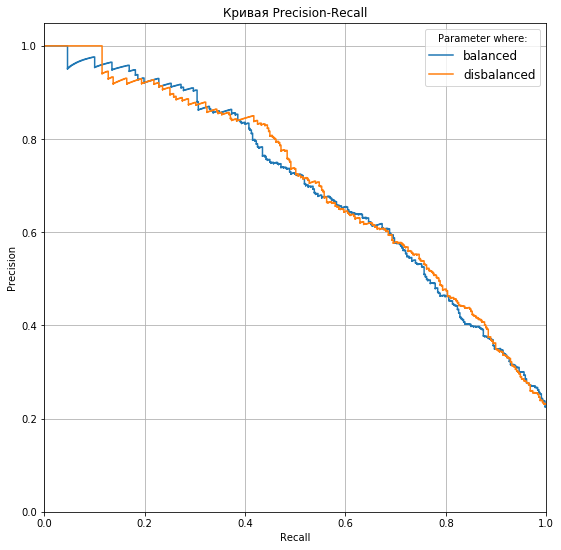

In [94]:
# обучим модель на увеличенной выборке
model = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
model_train = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7)
model_train.fit(features_train, target_train)

# получим массив "предсказаний" модели
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_valid_train = model_train.predict_proba(features_valid)
probabilities_one_valid_train = probabilities_valid_train[:, 1]

# посмотрим на значения точности, полноты и F1-меры в диапазоне порога от 0.24 до 0.6
print('Сбалансированная выборка')
print()
for number in np.arange(0.24, 0.62, 0.02):
    predicted_valid = probabilities_one_valid > number
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1score = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(number, precision, recall, f1score))
    
print('\nНесбалансированная выборка \n')
for number in np.arange(0.24, 0.62, 0.02):
    predicted_valid_train = probabilities_one_valid_train > number
    precision_train = precision_score(target_valid, predicted_valid_train)
    recall_train = recall_score(target_valid, predicted_valid_train)
    f1score_train = f1_score(target_valid, predicted_valid_train)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(number, precision_train, recall_train,
                                                                                          f1score_train))
# построим PR-график
precision, recall, number = precision_recall_curve(target_valid, probabilities_one_valid)
precision1, recall1, number = precision_recall_curve(target_valid, probabilities_one_valid_train)
plt.figure(figsize=(9, 9))
plt.step(recall, precision, where='post', label='balanced')
plt.step(recall1, precision1, where='post', label='disbalanced')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(b=None, which='major', axis='both')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(title='Parameter where:', fontsize='large')
plt.show()

Сравним модели случайный лес, обученные на выборке с дисбалансом и без дисбаланса. На сбалансированной выборке максимальное значение F1-меры наблюдается при значении порога 0.52. На выборке с дисбалансом примерно такое же значение F1-меры наблюдается при пороге 0.3. Таким образом, понятно как влияет дисбаланс классов на результаты предсказаний модели, они смещаются в сторону большего класса.

Посмотрим на значение F1-меры, а также на значение метрики AUC-ROC.

In [95]:
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.52
print('F1-мера: {:.3f}'.format(f1_score(target_valid, predicted_valid)))
print('Метрика ROC-AUC: {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid)))

F1-мера: 0.644
Метрика ROC-AUC: 0.869


Таким образом, с помощью изменения порога удалось еще увеличить значение F1-меры и получить достаточно высокое значение метрики AUC-ROC.

------

# 4. Тестирование модели

Для финального тестирования выбираем модель случайный лес. Она будет обучаться на данных, сбалансированных путем увеличения выборки. Также выберем значение порога 0.55. Посчитаем значение F1-меры и значение метрики AUC-ROC.

In [96]:
model_test = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=12345, min_samples_split=10, 
                                  min_samples_leaf=7, class_weight='balanced')
model_test.fit(features_upsampled, target_upsampled)

probabilities_test = model_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predict_test = model_test.predict(features_test)
print('F1-мера: {:.3f}'.format(f1_score(target_test, probabilities_one_test>0.55)))
print('Метрика ROC-AUC: {:.3f}'.format(roc_auc_score(target_test, probabilities_one_test)))

F1-мера: 0.634
Метрика ROC-AUC: 0.866


Построим ROC-кривую для наглядного сравнения результата нашей модели со случайной.

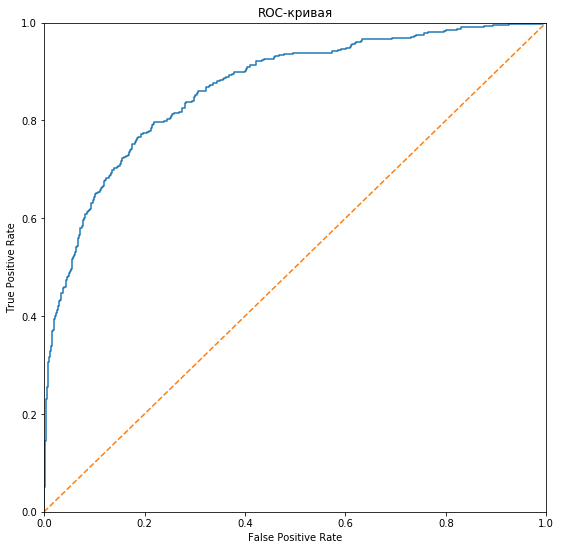

In [97]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(9, 9))

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

------

# Выводы

В ходе проекта было необходимо спрогнозировать уход клиентов из банка в ближайшее время. Решалась задача классификации. В данных были обнаружены пропуски, они заменены медианой значений столбца с пропусками. Категориальные признаки заменены на численные. Датасет был поделен на тренировочную, проверочную и тестовую выборки. Данные были приведены к одному масштабу, чтобы все признаки были одинаково значимы.

В ходе исследования в данных был обнаружен дисбаланс классов. По условию задачи обучение моделей производилось без учета дисбаланса и с учетом. Для исследования были выбраны следующие модели: решающее дерево, случайный лес и логистическая регрессия. Дисбаланс классов устранялся двумя способами: увеличением выборки и уменьшением выборки. Лучшие результаты F1-меры получились на сбалансированных данных с помощью увеличеним выборки. Также было произведено улучшение результата путем изменения порога. По полученным результатам для финального тестирования была выбрана модель случайный лес.

На тестовой выборке были получены следующие результаты:
* **F1-мера = 0.634**
* **Метрика AUC-ROC = 0.866**

Значение F1-меры удовлетворяет условию задачи проекта (не меньше 0.59), также значение метрики AUC-ROC говорит о высоком качестве построенной модели.

------